In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/Main_Data/Image/ADNI3/* .

In [ ]:
!cp -r /content/drive/MyDrive/Main_Data/Split/* .

In [ ]:
# !tar -xzf adni1_brain_resid.tar.gz

In [ ]:
# !tar -xzf adni1_brain_stand.tar.gz

In [ ]:
!cat adni3* | tar xzf -

## Load the images

In [ ]:
import glob

images = sorted(glob.glob('processed/**/*.nii.gz', recursive=True))

In [ ]:
import nibabel as nib

In [ ]:
import numpy as np

def check_files(files):
  corrupted = []

  for file_path in files:

    try:
      # Load the NIfTI file
      nifti_img = nib.load(file_path)

      # Get the image data and header
      img_data = nifti_img.get_fdata()

      img_header = nifti_img.header

    except Exception as e:
      corrupted.append(e)

  return corrupted


## Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class CNN3D11(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN3D11, self).__init__()

        self.conv1 = nn.Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2))
        self.batch_norm1 = nn.BatchNorm3d(32)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(16)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3 = nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm3 = nn.BatchNorm3d(8)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 4 * 4 * 5, 12)
        self.batch_norm_fc = nn.BatchNorm1d(12)
        self.fc2 = nn.Linear(12, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))

        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.fc2(x)

        return x


class CNN3D11_d(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN3D11_d, self).__init__()

        self.conv1 = nn.Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2))
        self.batch_norm1 = nn.BatchNorm3d(32)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(16)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3 = nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm3 = nn.BatchNorm3d(8)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 4 * 4 * 5, 12)
        self.batch_norm_fc = nn.BatchNorm1d(12)
        self.fc2 = nn.Linear(12, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = F.dropout3d(self.pool3(F.relu(self.batch_norm3(self.conv3(x)))), p=0.2)

        x = self.flatten(x)
        x = F.dropout(F.relu(self.batch_norm_fc(self.fc1(x))), p=0.2)
        x = self.fc2(x)

        return x


class Auto3dCNN11(nn.Module):
    def __init__(self, input_size=(182, 182, 218)): #input: (182, 182, 218)
        super(Auto3dCNN11, self).__init__()

        output_size = list(input_size)
        self.sizes = [[18, 18, 22], [37, 37, 44]]

        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()

        # Encoder

        self.encoder.append(nn.Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2)))
        self.encoder.append(nn.ReLU())
        self.encoder.append(nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.encoder.append(nn.Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.encoder.append(nn.ReLU())
        self.encoder.append(nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.encoder.append(nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.encoder.append(nn.ReLU())

        # Decoder

        self.decoder.append(nn.ConvTranspose3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.decoder.append(nn.ReLU())
        self.decoder.append(nn.Upsample(size=self.sizes[0], mode='trilinear', align_corners=False))
        self.decoder.append(nn.ConvTranspose3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.decoder.append(nn.ReLU())
        self.decoder.append(nn.Upsample(size=self.sizes[1], mode='trilinear', align_corners=False))
        self.decoder.append(nn.ConvTranspose3d(32, 1, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2), output_padding=(1, 1, 2)))
        self.decoder.append(nn.Tanh())

    def forward(self, x):

        outputs = []
        for i, layer in enumerate(self.encoder):
          if i % 3 == 0: # convolution
            x = layer(x)
          elif i % 3 == 1: # activation
            x = layer(x)
            outputs.append(x)
          else: # upsample
            x = layer(x)

        out_i = len(outputs) - 1
        for i, layer in enumerate(self.decoder):
          if i % 3 == 0: # convolution
            x = x + outputs[out_i]
            x = layer(x)
            out_i -= 1
          elif i % 3 == 1: # activation
            x = layer(x)
          else: # upsample
            x = layer(x)
        return x


class ConvBlock11(nn.Module):

  def __init__(self):
    super(ConvBlock11, self).__init__()

    self.conv1 = nn.Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2))
    self.batch_norm1 = nn.BatchNorm3d(32)
    self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

    self.conv2 = nn.Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    self.batch_norm2 = nn.BatchNorm3d(16)
    self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

    self.conv3 = nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    self.batch_norm3 = nn.BatchNorm3d(8)
    self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

  def forward(self, x):

    x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
    x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
    x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))

    return x


class FullNetwork11(nn.Module):

  def __init__(self, encoder, num_classes=3):
    super(FullNetwork11, self).__init__()

    self.encoder = encoder

    for param in list(self.encoder.parameters()):
        param.requires_grad = False

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(8 * 4 * 4 * 5, 12)
    self.batch_norm_fc = nn.BatchNorm1d(12)
    self.fc2 = nn.Linear(12, num_classes)

  def forward(self, x):

    x = self.encoder(x)

    x = self.flatten(x)
    x = F.relu(self.batch_norm_fc(self.fc1(x)))
    x = self.fc2(x)

    return x


In [ ]:
from torchsummary import summary

In [ ]:
model = CNN3D11()
summary(model, (1, 182, 182, 218), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 37, 37, 44]           4,032
       BatchNorm3d-2       [-1, 32, 37, 37, 44]              64
         MaxPool3d-3       [-1, 32, 18, 18, 22]               0
            Conv3d-4       [-1, 16, 18, 18, 22]          13,840
       BatchNorm3d-5       [-1, 16, 18, 18, 22]              32
         MaxPool3d-6         [-1, 16, 9, 9, 11]               0
            Conv3d-7          [-1, 8, 9, 9, 11]           3,464
       BatchNorm3d-8          [-1, 8, 9, 9, 11]              16
         MaxPool3d-9           [-1, 8, 4, 4, 5]               0
          Flatten-10                  [-1, 640]               0
           Linear-11                   [-1, 12]           7,692
      BatchNorm1d-12                   [-1, 12]              24
           Linear-13                    [-1, 3]              39
Total params: 29,203
Trainable params: 

## dataset creation

In [ ]:
import pandas as pd

testing_df = pd.read_csv('ADNI3_test.csv').drop('Unnamed: 0', axis=1)

In [ ]:
## if two classes:
testing_df = testing_df[testing_df['Group'] != 'MCI']

In [ ]:
test_images, test_labels, test_subjects = testing_df[['Image Data ID','Group','Subject']].T.to_numpy()

In [ ]:
import re

def make_id_translator(paths):
  return {re.search('((I|D)\d{3,8})\.', x).group(1): x for x in paths}

id_to_path = make_id_translator(images)

In [ ]:
def image_exists(sample):
  image_id, group = sample
  return image_id in id_to_path

test_set = list(zip(test_images, test_labels))

test_set = list(filter(image_exists, test_set))

test_images, test_labels = zip(*test_set)

In [ ]:
test_image_paths = [id_to_path[k] for k in test_images]

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import nibabel as nib
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
from torch.utils.data import WeightedRandomSampler, RandomSampler


class CNNDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load NIfTI image
        nifti_img = nib.load(file_path)

        # Get the image data
        img_data = nifti_img.get_fdata()

        # Assuming the data is in a reasonable range, you may normalize it
        max_i = img_data.max()
        min_i = img_data.min()
        img_data = (img_data - min_i) / (max_i - min_i)

        # Expand dimensions to add a channel (assuming grayscale images)
        img_data = np.expand_dims(img_data, axis=0)

        # Permute dimensions to match [batch_size, channels, depth, height, width]
        # (182, 218, 182) -> (182, 182, 218)
        img_data = torch.FloatTensor(img_data).permute(0, 3, 1, 2)

        if self.transform:
            img_data = self.transform(img_data)

        return img_data, torch.FloatTensor(label)


# Convert labels to one-hot encoding
le = LabelEncoder()
y_test_encoded = le.fit_transform(test_labels)
n_classes = len(le.classes_)

y_test_one_hot = torch.nn.functional.one_hot(torch.tensor(y_test_encoded), num_classes=n_classes).float()

# Create custom datasets
test_dataset = CNNDataset(file_paths=test_image_paths, labels=y_test_one_hot)

batch_size = 2
num_workers = 8

# Create data loaders
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
len(test_loader)

113

## load the pretrained models

In [ ]:
import os, shutil, re

def prepare_model(filename="Auto3dCNN11_ppmi.pth", num_classes=2):

  if not os.path.isfile(filename):
    shutil.copy(f'/content/drive/MyDrive/Main_Data/Checkpoints3/part2/{filename}', filename)

  autoencoder = Auto3dCNN11()

  if not torch.cuda.is_available():
    checkpoint = torch.load(filename, map_location=torch.device('cpu'))
  else:
    checkpoint = torch.load(filename)

  autoencoder.load_state_dict(checkpoint['model_state_dict'], strict=False)

  encoder_dict = autoencoder.encoder.state_dict()

  new_encoder_dict = {}
  for k,v in encoder_dict.items():
    layer = int(re.search('\d+', k).group(0)) // 3 + 1
    part = re.search('\..*', k).group(0)
    new_encoder_dict[f'conv{layer}{part}'] = v

  conv_block = ConvBlock11()

  conv_block.load_state_dict(new_encoder_dict, strict=False)

  if num_classes == 2 or num_classes == 3:
    model = FullNetwork11(encoder=conv_block, num_classes=num_classes)
  else:
    raise Exception('you should only use 2 or 3 classes for your model.')

  return model

## Testing

In [ ]:
params_filename = '3c_combined_fullnetwork11_adni3.pth'

In [ ]:
!cp /content/drive/MyDrive/Main_Data/Checkpoints3/part2/$params_filename .

In [ ]:
import shutil
import os

def load_checkpoint(filename, model, optimizer, scheduler=None, early_stopper=None):

    if not torch.cuda.is_available():
      checkpoint = torch.load(filename, map_location=torch.device('cpu'))
    else:
      checkpoint = torch.load(filename)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']

    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler'])

    if early_stopper is not None:
        early_stopper.load_state_dict(checkpoint['early_stopper'])

    return epoch, train_losses, test_losses


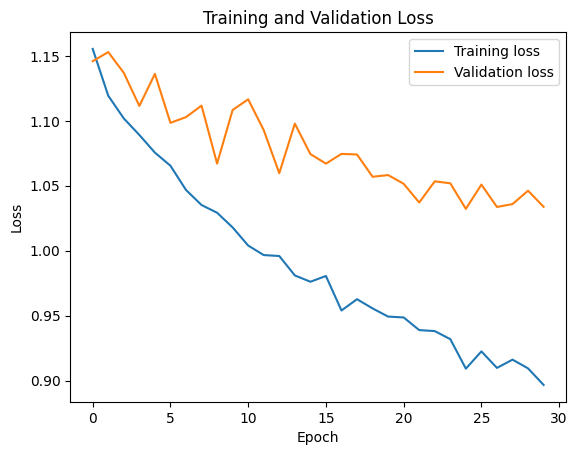

In [ ]:
import torch
import torch.optim as optim
import os

# Instantiate the model
model = prepare_model(num_classes=3)
# model = CNN3D11()

# Number of training epochs
num_epochs = 20

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=4e-5) #lr=0.001

s_epoch = -1

# Initialize the loss arrays
train_losses = []
valid_losses = []

# Load the training data if needed
if os.path.isfile(params_filename):
  s_epoch, train_losses, valid_losses = load_checkpoint(params_filename, model, optimizer, scheduler=None, early_stopper=None)

import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def pad(s, pad=10, pad_up_down=False):
    lines = s.split('\n')
    new_lines = [' ' * pad + line for line in lines]
    if pad_up_down:
        new_lines.insert(0, '\n')
        new_lines.append('\n')
    return '\n'.join(new_lines)

def get_report(y_true, y_pred, classes=None):
    confusion_arr = confusion_matrix(y_true, y_pred)
    confusion_rep = str(pd.DataFrame(confusion_arr, columns=[f'pred_{cl}' for cl in classes], index=[f'true_{cl}' for cl in classes]))
    splitter = '\n' + '='*60 + '\n'
    report = classification_report(y_true, y_pred, target_names=classes)

    return splitter + pad(confusion_rep) + splitter + report + splitter

In [ ]:
from tqdm.notebook import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Validation step
model.eval()

y_true_test = []
y_pred_test = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        y_true_test.extend(torch.argmax(target, dim=1).cpu().numpy())
        y_pred_test.extend(torch.argmax(output, dim=1).cpu().numpy())


# Testing metrics

test_report = get_report(y_true_test, y_pred_test, le.classes_)
print(test_report)

  0%|          | 0/113 [00:00<?, ?it/s]


                    pred_AD  pred_CN  pred_MCI
          true_AD        11        3         5
          true_CN        14       67        35
          true_MCI       32       30        29
              precision    recall  f1-score   support

          AD       0.19      0.58      0.29        19
          CN       0.67      0.58      0.62       116
         MCI       0.42      0.32      0.36        91

    accuracy                           0.47       226
   macro avg       0.43      0.49      0.42       226
weighted avg       0.53      0.47      0.49       226




## save report

In [ ]:
report_name = params_filename.replace('.pth', '_report.txt')

In [ ]:
with open(report_name, 'w') as f:
  f.write(test_report)

In [ ]:
!cp $report_name /content/drive/MyDrive/Main_Data/Reports3/part2/$report_name

## Save confusion matrix

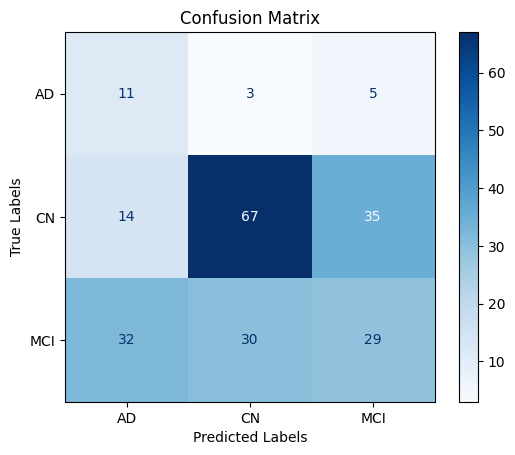

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)

# Add titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
matrix_name = params_filename.replace('.pth', '_matrix.png')
plt.savefig(matrix_name)

In [ ]:
!cp $matrix_name /content/drive/MyDrive/Main_Data/Reports3/part2/$matrix_name